In [34]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2

In [35]:
!pip install -Uqq fastbook

In [36]:
from fastbook import *
from fastai.vision.widgets import *

In [37]:
df_train = pd.read_csv('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')
df_train.head(10)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
5,0083ee8054ee,4
6,0097f532ac9f,0
7,00a8624548a9,2
8,00b74780d31d,2
9,00cb6555d108,1


In [38]:
#df_train.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
#df_train.rename(columns={'image': 'id_code'}, inplace=True)
#df_train.rename(columns={'level': 'diagnosis'}, inplace=True)
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

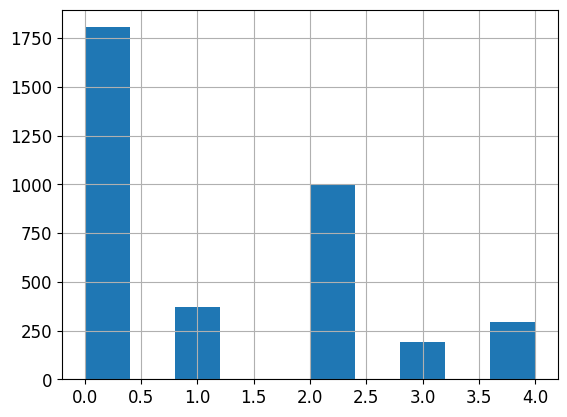

In [39]:
df_train['diagnosis'].hist()
df_train['diagnosis'].value_counts()

In [40]:
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df_train['type'] = df_train['diagnosis'].map(diagnosis_dict.get)
df_train.head(10)

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR
5,0083ee8054ee,4,Proliferate_DR
6,0097f532ac9f,0,No_DR
7,00a8624548a9,2,Moderate
8,00b74780d31d,2,Moderate
9,00cb6555d108,1,Mild


<Axes: ylabel='type'>

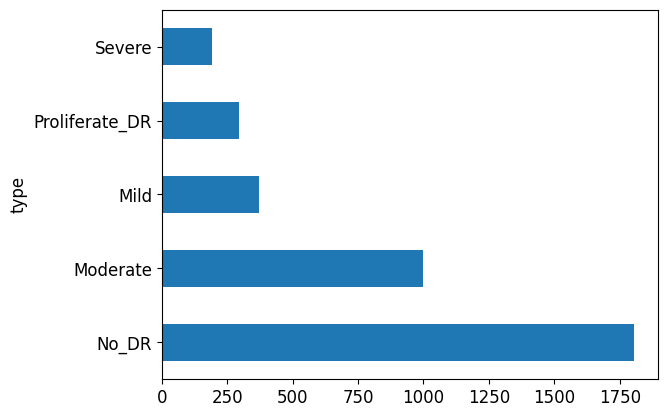

In [41]:
df_train['type'].value_counts().plot(kind='barh')

In [42]:
# train, test = train_test_split(df_train, test_size = 0.1, stratify = df_train['type'])
train = df_train
print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
# print("For Testing Dataset :")
# print(test['type'].value_counts(), '\n')


For Training Dataset :
type
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64 



In [43]:
#histogram eq
def preprocessing1(img):
    red, green, blue = cv2.split(img)
    hist_red = cv2.equalizeHist(red)
    hist_green = cv2.equalizeHist(green)
    hist_blue = cv2.equalizeHist(blue)
    img_eq = cv2.merge((hist_red, hist_green, hist_blue))
    return img_eq

#gaussian blur
def preprocessing2(img):
    img_ben = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
    return img_ben

def preprocessing3(image, kernel_size=30, sigma=19.9, theta = 0, lambda_=9.8, gamma=6.08):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gabor_kernel = cv2.getGaborKernel(
        (kernel_size, kernel_size), 
        sigma, 
        theta, 
        lambda_, 
        gamma, 
        ktype=cv2.CV_32F
    )

    filtered_image = cv2.filter2D(image, cv2.CV_32F, gabor_kernel)
    filtered_rgb_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2RGB)
#     print(filtered_rgb_image.shape)
    return filtered_rgb_image

def preprocessing4(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    kernel = np.ones((1000,1000), np.float64)
    background = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    
    shading_correction = cv2.subtract(gray, background)
    shading_correction = cv2.cvtColor(shading_correction, cv2.COLOR_GRAY2RGB)
    shading_correction = cv2.resize(shading_correction,(224,224))
    return shading_correction

In [44]:
def apply_gaussian_filter(image, sigmaX=10):
    # Applying Gaussian blur
    gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    return gaussian

In [46]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
#test_dir = os.path.join(base_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
# os.makedirs(test_dir)

In [47]:
src_dir = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images"


for index,row in train.iterrows():
    diagnosis = row['type']
    #diagnosis_bia = row['diagnosis']
    if diagnosis == 'No_DR':
        continue
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir,diagnosis,id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    image = cv2.imread(srcfile)
    processed_image = apply_gaussian_filter(image)
    dstfile_processed = os.path.join(dstfile, id_code)
    cv2.imwrite(dstfile_processed, processed_image)
#
# for index, row in test.iterrows():
#     diagnosis = row['type']
#     id_code = row['image'] + ".jpeg"
#     srcfile = os.path.join(src_dir,id_code)
#     dstfile = os.path.join(test_dir, diagnosis)
#     os.makedirs(dstfile, exist_ok = True)
#     shutil.copy(srcfile, dstfile)
    
#     image = cv2.imread(srcfile)
    
#     processed_image = preprocessing2(image)
#     dstfile_processed = os.path.join(dstfile, id_code)
#     cv2.imwrite(dstfile_processed, processed_image)"


In [48]:
train_path = 'train'
#test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
#test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 1857 images belonging to 4 classes.


In [49]:
train_path=Path("/kaggle/working/train")
#test_path=Path("/kaggle/working/test")

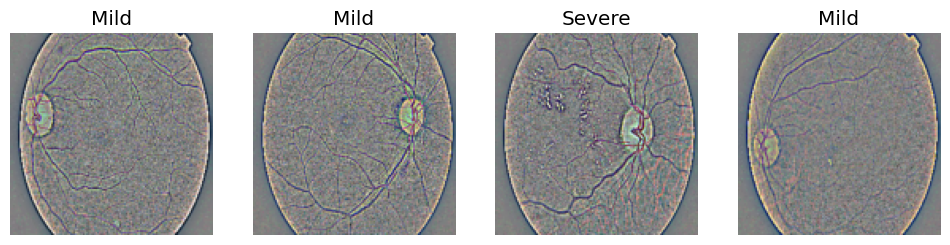

In [50]:
dc = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
dls = dc.dataloaders(train_path)
dls.valid.show_batch(max_n=4,nrows=1)

In [51]:
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.062423,1.575840,0.605405,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.583921,1.447472,0.497297,00:04
1,1.236522,1.520468,0.459459,00:04
2,0.937880,1.520671,0.448649,00:04
3,0.672096,1.558119,0.443243,00:04
4,0.483079,1.550547,0.459459,00:04


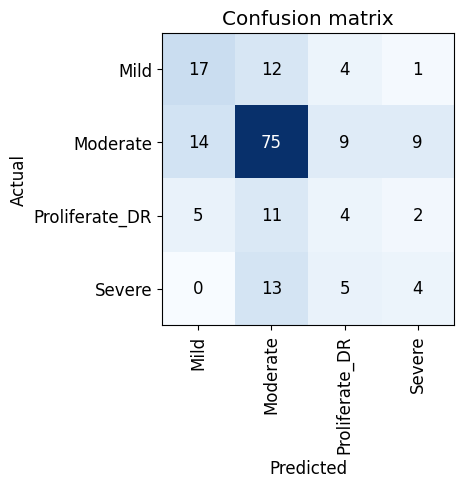

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

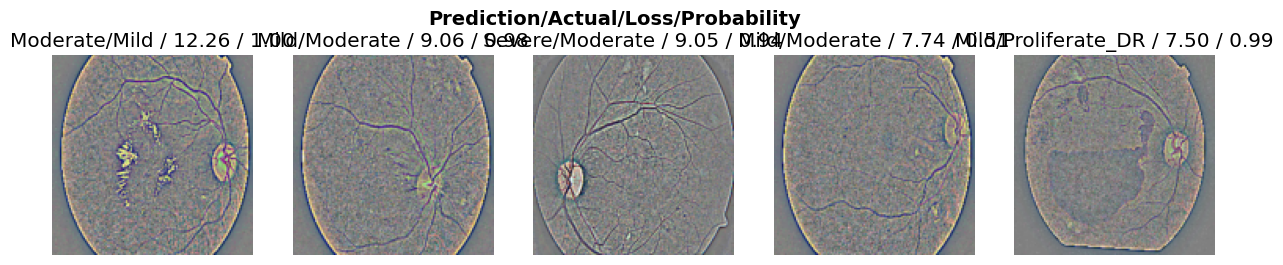

In [53]:
interp.plot_top_losses(5,nrows=1)

In [54]:

# test_db = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files,
#     #splitter=GrandparentSplitter(valid_name='test'),
    
#     get_y=parent_label,
#     item_tfms=Resize(224)
# )


# test_dl = test_db.dataloaders(test_path)
# learn.test_dl = test_dl
# results = learn.validate()
# #print(f"loss:{results[0]}")
# print(f"accuracy:{1-results[1]}")

In [55]:
pred,idx,probs = learn.predict(PILImage.create('/kaggle/working/train/Moderate/b98f77098b9d.png'))
print(pred)
print(f"The probability of {pred} '{probs[idx]:.4f}'")

Moderate
The probability of Moderate '0.9318'


In [60]:
image = cv2.imread('/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/54_left.jpeg') 
abc = preprocessing2(image)
pred,idx,probs = learn.predict(PILImage.create(abc))
print(pred)
print(f"The probability of {pred} '{probs[idx]:.4f}'")

Moderate
The probability of Moderate '0.4722'


In [61]:
learn.export('/kaggle/working/stage-2_resnet.pkl')

In [62]:
ls

stage-2_resnet.pkl  train/


In [63]:
from IPython.display import FileLink 
FileLink(r'stage-2_resnet.pkl')

/kaggle/working/stage-2_resnet.pkl